In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [39]:
cd ../src

/home/theo/mva/dlmi/pneumothorax_segmentation/src


In [40]:
from util import *
from params import *
from imports import *
from data.masks import *
from data.dataset import dicom_to_dict

In [41]:
from glob import glob
from tqdm import tqdm_notebook as tqdm

In [42]:
sns.set_style('white')
KERNEL_START_TIME = time.time()
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
print('Number of available cores :', multiprocessing.cpu_count())

Number of available cores : 16


In [19]:
seed_everything(seed)

# Data

In [20]:
rles_train = pd.read_csv(DATA_PATH + 'train-rle.csv')
rles_train.columns = ['ImageId', 'EncodedPixels']

print('Number of training images : ', len(rles_train))

Number of training images :  12954


In [21]:
train_files = sorted(glob(f'{TRAIN_IMG_PATH}*/*/*.dcm'))

train_metadata = []

for file_path in tqdm(train_files):
    dicom_data = pydicom.dcmread(file_path)
    train_metadata.append(dicom_to_dict(dicom_data, file_path, rles_train))

df_train = pd.DataFrame(train_metadata)

/nix/store/35d7vxikaanz8ypzzrihyk5q00gphhkh-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [22]:
df_train.head(7).tail(2)

,patient_name,patient_id,patient_age,patient_sex,pixel_spacing,file_path,id,rle,has_pneumothorax,encoded_pixels_count
5,3d911758-b2f0-4dff-8165-80c129ffa134,3d911758-b2f0-4dff-8165-80c129ffa134,45,F,"[0.171, 0.171]",../input/siim/dicom-images-train/1.2.276.0.723...,1.2.276.0.7230010.3.1.4.8323329.10004.15178752...,-1,False,1
6,bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1,bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1,53,F,"[0.14300000000000002, 0.14300000000000002]",../input/siim/dicom-images-train/1.2.276.0.723...,1.2.276.0.7230010.3.1.4.8323329.10005.15178752...,209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...,True,1


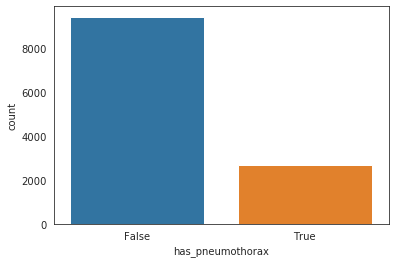

In [23]:
sns.countplot(df_train['has_pneumothorax'])
plt.show()

In [24]:
mask = rle_to_mask(df_train['rle'][6], IMG_SHAPE)
img = pydicom.dcmread(df_train['file_path'][6]).pixel_array

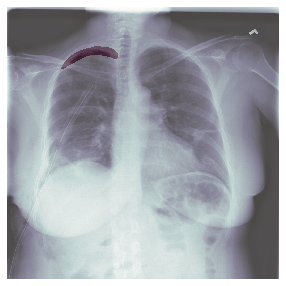

In [25]:
plot_mask(img, mask)

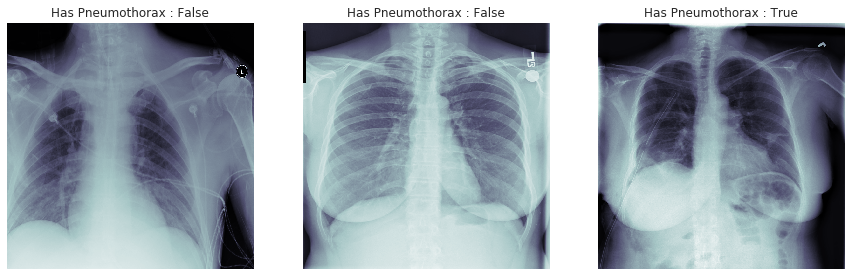

In [26]:
i = 4
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
data = pydicom.dcmread(df_train['file_path'][i])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i]}")
plt.axis(False)
          
plt.subplot(1, 3, 2)
data = pydicom.dcmread(df_train['file_path'][i+1])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i+1]}")
plt.axis(False)
          
plt.subplot(1, 3, 3)
data = pydicom.dcmread(df_train['file_path'][i+2])
plt.imshow(data.pixel_array, cmap=plt.cm.bone)
plt.title(f"Has Pneumothorax : {df_train['has_pneumothorax'][i+2]}")
plt.axis(False)
plt.show()

## Saving images of different resolutions to disk

In [27]:
from data.lower_res import *

In [28]:
ratio = 4

### Images

In [29]:
folder = DATA_PATH + f'train_images_{ratio}/'

if not os.path.exists(folder):
    os.mkdir(folder)

In [31]:
resized_rles = []

for i in tqdm(range(len(df_train))):
    img = pydicom.dcmread(df_train['file_path'][i]).pixel_array
    name  = df_train['id'][i]
    mask = df_train['rle'][i]
    
    resized_img, resized_rle = lower_res(img, mask, ratio=ratio)
    
    resized_rles.append(resized_rle)
    cv2.imwrite(folder + name + '.png', resized_img)

/nix/store/35d7vxikaanz8ypzzrihyk5q00gphhkh-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


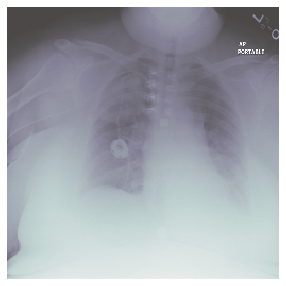

In [32]:
plot_mask(resized_img, resized_rle)

In [33]:
df_train['rle_4'] = resized_rles

In [34]:
df_train['rle_1'] = df_train['rle'].copy()

In [35]:
df_train.to_csv('../output/df_train.csv', index=False)